In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

!pip install metric-learn

from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from metric_learn import RCA_Supervised

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 544.4 kB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

data = np.load('/content/drive/MyDrive/dml/indian-veriseti/indianpinearray.npy')

gt = np.load('/content/drive/MyDrive/dml/indian-veriseti/IPgt.npy')


def applyPCA(X, numComponents=15):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX


data=applyPCA(data)


df = pd.DataFrame(data.reshape(data.shape[0]*data.shape[1], -1))
df['class'] = gt.ravel()

X = df[df['class']!=0].iloc[:, :-1].values

y = df[df['class']!=0].iloc[:, -1].values



Mounted at /content/drive


In [3]:


acc_list = []

kf = KFold(n_splits=5, shuffle=True,random_state=42)


rca = RCA_Supervised(n_chunks=30, chunk_size=2)
knn = KNeighborsClassifier(n_neighbors=5)

f_index = 1
for train_index, test_index in kf.split(X):
    print(f"Fold {f_index} -> Train: {len(train_index)}, Test: {len(test_index)}")

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    rca.fit(X_train, y_train)
    knn.fit(rca.transform(X_train), y_train)


    rca_acc = knn.score(rca.transform(X_test), y_test)
    print('rca accuracy  {}'.format(rca_acc))

    acc_list.append(rca_acc)

    f_index += 1

print("Ortalaması Başarı:", np.mean(acc_list))
print("Standart sapma:",np.std(acc_list) )

Fold 1 -> Train: 8199, Test: 2050
rca accuracy  0.7658536585365854
Fold 2 -> Train: 8199, Test: 2050
rca accuracy  0.7839024390243903
Fold 3 -> Train: 8199, Test: 2050
rca accuracy  0.7604878048780488
Fold 4 -> Train: 8199, Test: 2050
rca accuracy  0.78
Fold 5 -> Train: 8200, Test: 2049
rca accuracy  0.8135675939482675
Ortalaması Başarı: 0.7807622992774584
Standart sapma: 0.018546976185617976


In [4]:
import joblib

joblib.dump(rca, 'rca_indian_model.pkl')
joblib.dump(knn,'rca_indian_knn_model.pkl')

rca_loaded = joblib.load('rca_indian_model.pkl')
knn_loaded =joblib.load('rca_indian_knn_model.pkl')

rca_data=rca_loaded.transform(X)
pred=knn_loaded.predict(rca_data)

In [5]:

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score

print("accuracy:",accuracy_score(pred,y))
print("cohen kappa:", cohen_kappa_score(pred,y))
print("f1 score:",f1_score(pred,y,average='macro'))

accuracy: 0.8531564055029759
cohen kappa: 0.8323261120476424
f1 score: 0.8469687430098789


In [6]:
gt_2 = gt.copy()
gt_2=gt_2.reshape(-1)


i = 0
j=0
while(i<(gt.shape[0]*gt.shape[1])):
      if(gt_2[i] != 0):
          gt_2[i]=pred[j]
          j += 1
      i += 1

In [7]:
gt_2=gt_2.reshape(data.shape[0],-1)

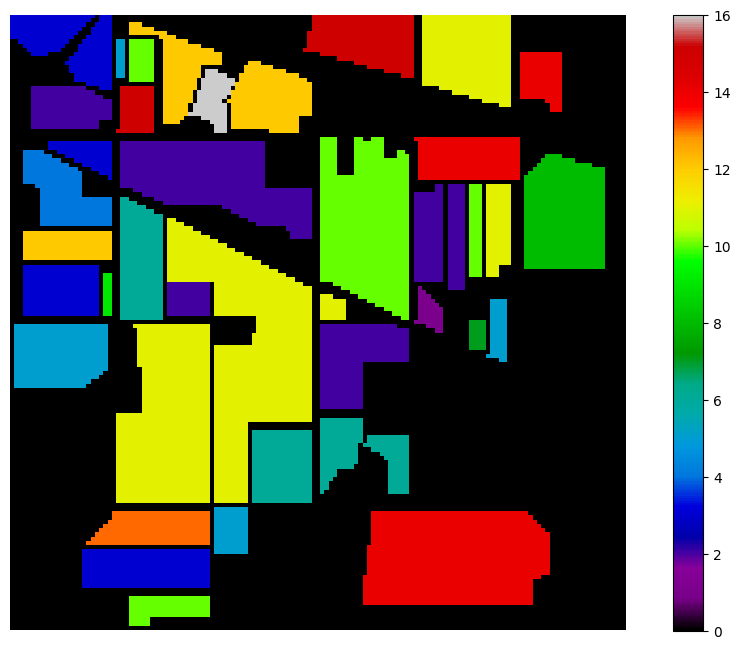

In [8]:
def plot_gt(data):
  fig = plt.figure(figsize=(12, 8))
  plt.imshow(data,cmap='nipy_spectral')
  plt.colorbar()
  plt.axis('off')
  plt.show()

plot_gt(gt)

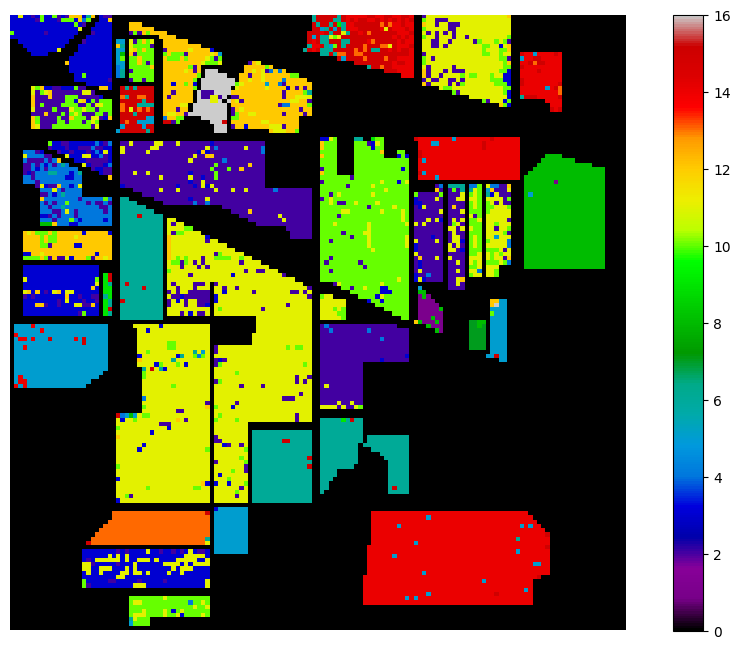

In [9]:
plot_gt(gt_2)